In [1]:
# see more styles and js code (linked at the bottom) at https://www.tylerxhobbs.com/words/flow-fields

In [2]:
from vfield import render_flow_field
import torch
import matplotlib.pyplot as plt
from PIL import Image

vfield = torch.load('../data/vectorfield.pt')

grid = vfield['grid']
displacement=vfield['displacement']

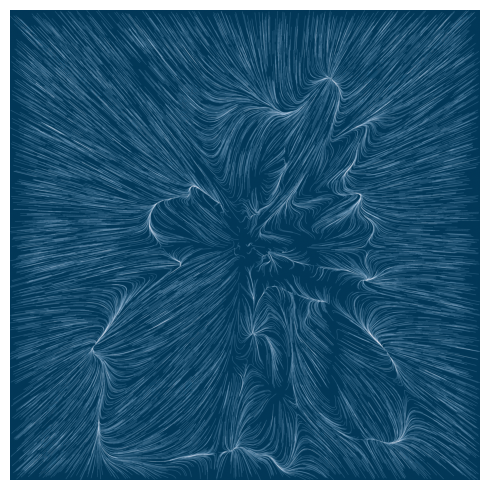

In [3]:
ff_img = render_flow_field(grid, displacement, 
                           W=5600, H=5600, 
                           steps=500, 
                           step_size=0.0001,
                           particles=10_000,
                           bg_color=255,
                           antialias=True,
                           aa_factor=2)

plt.figure(figsize=(10, 5))
plt.imshow(ff_img, cmap='PuBu', origin='lower')
plt.axis('off')
plt.tight_layout()
plt.show()

ff_img = ff_img.transpose(Image.FLIP_TOP_BOTTOM)
ff_img.save('../flow-field.png')
ff_img.show()

In [4]:
# Test different antialiasing factors
import time

# Create smaller images for comparison
W, H = 1400, 1400
particles_test = 2000
steps_test = 300

# Test without antialiasing
print("Rendering without antialiasing...")
start_time = time.time()
ff_img_no_aa = render_flow_field(grid, displacement, 
                                 W=W, H=H, 
                                 steps=steps_test, 
                                 step_size=0.0001,
                                 particles=particles_test,
                                 bg_color=255,
                                 antialias=False)
time_no_aa = time.time() - start_time
print(f"Time without AA: {time_no_aa:.2f}s")

# Test with 2x supersampling antialiasing
print("Rendering with 2x supersampling antialiasing...")
start_time = time.time()
ff_img_aa_2x = render_flow_field(grid, displacement, 
                                 W=W, H=H, 
                                 steps=steps_test, 
                                 step_size=0.0001,
                                 particles=particles_test,
                                 bg_color=255,
                                 antialias=True,
                                 aa_factor=2)
time_aa_2x = time.time() - start_time
print(f"Time with 2x AA: {time_aa_2x:.2f}s")

# Test with 4x supersampling antialiasing for highest quality
print("Rendering with 4x supersampling antialiasing...")
start_time = time.time()
ff_img_aa_4x = render_flow_field(grid, displacement, 
                                 W=W, H=H, 
                                 steps=steps_test, 
                                 step_size=0.0001,
                                 particles=particles_test,
                                 bg_color=255,
                                 antialias=True,
                                 aa_factor=4)
time_aa_4x = time.time() - start_time
print(f"Time with 4x AA: {time_aa_4x:.2f}s")

Rendering without antialiasing...
Time without AA: 10.17s
Rendering with 2x supersampling antialiasing...
Time without AA: 10.17s
Rendering with 2x supersampling antialiasing...
Time with 2x AA: 8.77s
Rendering with 4x supersampling antialiasing...
Time with 2x AA: 8.77s
Rendering with 4x supersampling antialiasing...
Time with 4x AA: 8.19s
Time with 4x AA: 8.19s


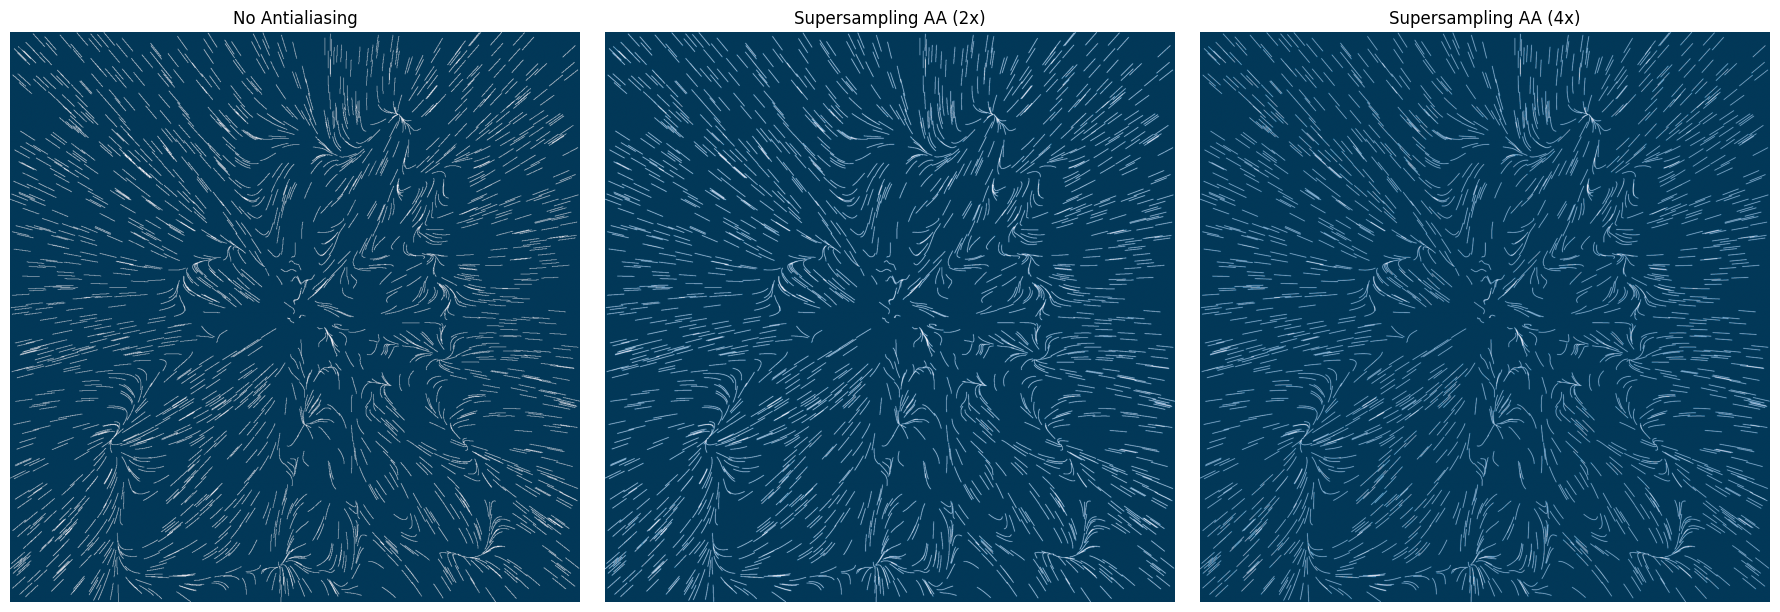

In [5]:
# Compare the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(ff_img_no_aa, cmap='PuBu', origin='lower')
axes[0].set_title('No Antialiasing')
axes[0].axis('off')

axes[1].imshow(ff_img_aa_2x, cmap='PuBu', origin='lower')
axes[1].set_title('Supersampling AA (2x)')
axes[1].axis('off')

axes[2].imshow(ff_img_aa_4x, cmap='PuBu', origin='lower')
axes[2].set_title('Supersampling AA (4x)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Save the antialiased versions
ff_img_aa_2x.transpose(Image.FLIP_TOP_BOTTOM).save('../flow-field-aa-2x.png')
ff_img_aa_4x.transpose(Image.FLIP_TOP_BOTTOM).save('../flow-field-aa-4x.png')

Rendering final high-quality image with 4x supersampling antialiasing...


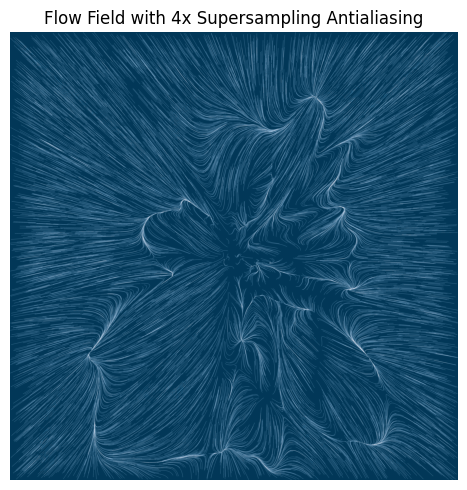

Saved ultra high-quality antialiased flow field to '../flow-field-high-quality.png'


In [6]:
# Now let's use antialiasing with the original large parameters
print("Rendering final high-quality image with 4x supersampling antialiasing...")
ff_img_final = render_flow_field(grid, displacement, 
                                 W=5600, H=5600, 
                                 steps=500, 
                                 step_size=0.0001,
                                 particles=10_000,
                                 bg_color=255,
                                 antialias=True,
                                 aa_factor=4)

plt.figure(figsize=(10, 5))
plt.imshow(ff_img_final, cmap='PuBu', origin='lower')
plt.axis('off')
plt.title('Flow Field with 4x Supersampling Antialiasing')
plt.tight_layout()
plt.show()

ff_img_final = ff_img_final.transpose(Image.FLIP_TOP_BOTTOM)
ff_img_final.save('../flow-field-high-quality.png')
print("Saved ultra high-quality antialiased flow field to '../flow-field-high-quality.png'")